<a href="https://colab.research.google.com/github/SergioMartinezCid/MUII-DSI-2022-23/blob/master/Clustering/DSI_Trabajo_Cl%C3%BAstering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO
* Hacer agregación de goles, fallos y efectividad
* EGGoals y EGMissed considerar quitarlos por falta de datos (wtf? tiene bastantes)
* Time, scoring, prod100 son complicados y probar con ellos y sin ellos
* Validación (opcional)
* Considerar quitar los partidos de la President Cup para las selecciones y no para los jugadores (Probar a hacerlo con y sin) (Chile queda muy alto pero porque en la president se enfrenta a equipos topochos)
* Scoring: Metrica inventada que puntúa en función de todo lo demás. Es información agregada. Lo suyo sería quitarlo.
* Jackknife (no se como se llama) para detectar outliers.

# Importación de Datos

In [ ]:
!wget -O CSVORIGINAL.csv https://raw.githubusercontent.com/SergioMartinezCid/MUII-DSI-2022-23/master/Clustering/CSVORIGINAL.csv

--2023-02-27 18:47:14--  https://raw.githubusercontent.com/SergioMartinezCid/MUII-DSI-2022-23/master/Clustering/CSVORIGINAL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350830 (343K) [text/plain]
Saving to: ‘CSVORIGINAL.csv’

CSVORIGINAL.csv     100%[===================>] 342.61K  --.-KB/s    in 0.03s   

2023-02-27 18:47:14 (10.0 MB/s) - ‘CSVORIGINAL.csv’ saved [350830/350830]



In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.decomposition import PCA

In [ ]:
original_df = pd.read_csv('CSVORIGINAL.csv', delimiter='\t', decimal=',')

In [ ]:
# Se borra la última fila, que es nula
original_df = original_df.drop(3071, axis=0)
# Se elimina la columna prod100 por tener información agregada con scoring
original_df = original_df.drop(['prod100'], axis=1)
# Se eliminan las columnas de las tarjetas roja, amarilla y azul por no tener información relevante (hay muy pocas situaciones en las que se haya sacado tarjeta)
original_df = original_df.drop(['YC', 'RC', 'BC'], axis=1)
# Comprobamos si ha quedado algún valor nulo
original_df.isnull().values.any()
original_df.head()

,Phase,Match No.,Match,Team,No.,Name,7mGoals,7mMissed,6mGoals,6mMissed,...,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time,scoring
0,Group Phase,1.0,EGY-CHI,EGY,5.0,OMAR Yahia,0.0,0.0,2.0,0.0,...,0.0,1.0,3.0,3.0,2.0,4.0,1.0,0.0,47.583333,1.75
1,Group Phase,1.0,EGY-CHI,EGY,11.0,MOAMEN Ahmed,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.033333,-0.40
2,Group Phase,1.0,EGY-CHI,EGY,15.0,HESHAM Ahmed,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,20.550000,-2.25
3,Group Phase,1.0,EGY-CHI,EGY,24.0,ELMASRY Ibrahim,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,29.800000,2.80
4,Group Phase,1.0,EGY-CHI,EGY,25.0,NAWAR Wisam,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.250000,0.00


# Identificar los porteros

Vamos a eliminar los porteros y jugadores defensivos ya que como los datos son mayormente ofensivos, los va a agrupar todos en un solo cluster.

In [ ]:
#Agrupamos por jugador
# Quitamos Phase, Match No., Match, No. y Team por ser columnas identificativas que no son relevantes para los jugadores
player_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Team'], axis=1)
# Establecer la columna Name como index porque es una columna identificativa
player_df = player_df.groupby(['Name'], as_index=False).sum()
#Seleccionamos los porteros que serán las filas que tienen tiempo pero 0 scoring
only_goalkeepers = player_df[(player_df.scoring==0)&(player_df.Time > 0)]
only_goalkeepers.head()

,Name,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,...,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time,scoring
7,ABIDI Mohamed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.783333,0.0
16,ALDERI Ali,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.866667,0.0
23,ALMEIDA Cesar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.533333,0.0
24,ALMEIDA Luis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.466667,0.0
28,ALSHUWAIKH Qasim,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.733333,0.0


# Agregación de Datos

## Por equipos

### Incluyendo porteros

In [ ]:
# Quitamos Phase, Match No., Match, No. y Name por ser columnas identificativas que no son relevantes para los equipos
team_goalkeepers_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Name'], axis=1)

# Quitamos Time porque para los equipos no es relevante porque jugarán más los que lleguen a la final
#team_goalkeepers_df = team_goalkeepers_df.drop('Time',axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
team_goalkeepers_df = team_goalkeepers_df.drop('scoring',axis=1)
# Establecer la columna Team como index porque es una columna identificativa
team_goalkeepers_df = team_goalkeepers_df.groupby(['Team'], as_index=True).sum()

# Normalizamos los datos
team_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
team_goalkeepers_df.head()

,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time
Team,,,,,,,,,,,,,,,,,,,,
ALG,0.464286,0.428571,0.305556,0.580645,0.265306,0.538462,0.600000,0.333333,0.062500,0.357143,0.454545,0.333333,0.508475,0.911765,0.546512,0.628571,0.259542,0.390244,0.100000,2520.0
ANG,0.464286,1.000000,0.402778,0.354839,0.346939,0.269231,0.533333,0.066667,0.104167,0.357143,0.090909,0.166667,0.796610,0.882353,0.651163,0.600000,0.396947,0.195122,0.300000,2520.0
ARG,0.250000,0.357143,0.347222,0.548387,0.244898,0.576923,0.333333,0.266667,0.333333,0.214286,0.545455,0.333333,0.203390,0.294118,0.546512,0.457143,0.244275,0.097561,0.100000,2100.0
AUT,0.750000,0.428571,0.597222,0.387097,0.571429,0.461538,0.822222,0.200000,0.562500,0.642857,0.363636,0.500000,0.559322,0.661765,0.755814,0.828571,0.641221,0.707317,0.400000,2940.0
BLR,0.214286,0.142857,0.500000,0.645161,0.612245,0.576923,0.400000,0.066667,0.229167,0.071429,0.272727,0.333333,0.677966,0.632353,0.488372,0.742857,0.374046,0.170732,0.433333,2520.0


### Excluyendo porteros

In [ ]:
# Eliminamos los porteros
team_no_goalkeepers_df = original_df.copy()
team_no_goalkeepers_df = team_no_goalkeepers_df[~team_no_goalkeepers_df['Name'].isin(only_goalkeepers['Name'])]
# Quitamos Phase, Match No., Match, No. y Name por ser columnas identificativas que no son relevantes para los equipos
team_no_goalkeepers_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Name'], axis=1)
# Quitamos Time porque para los equipos no es relevante porque jugarán más los que lleguen a la final
#team_no_goalkeepers_df = team_no_goalkeepers_df.drop('Time',axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
team_no_goalkeepers_df = team_no_goalkeepers_df.drop('scoring',axis=1)
# Establecer la columna Team como index porque es una columna identificativa
team_no_goalkeepers_df = team_no_goalkeepers_df.groupby(['Team'], as_index=True).sum()
# Normalizamos los datos
team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']] = min_max_scaler.fit_transform(team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])

team_no_goalkeepers_df.head()

,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,FBGoals,FBMissed,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,Time
Team,,,,,,,,,,,,,,,,,,,,
ALG,0.464286,0.428571,0.305556,0.580645,0.265306,0.538462,0.600000,0.333333,0.062500,0.357143,0.454545,0.333333,0.508475,0.911765,0.546512,0.628571,0.259542,0.390244,0.100000,2520.0
ANG,0.464286,1.000000,0.402778,0.354839,0.346939,0.269231,0.533333,0.066667,0.104167,0.357143,0.090909,0.166667,0.796610,0.882353,0.651163,0.600000,0.396947,0.195122,0.300000,2520.0
ARG,0.250000,0.357143,0.347222,0.548387,0.244898,0.576923,0.333333,0.266667,0.333333,0.214286,0.545455,0.333333,0.203390,0.294118,0.546512,0.457143,0.244275,0.097561,0.100000,2100.0
AUT,0.750000,0.428571,0.597222,0.387097,0.571429,0.461538,0.822222,0.200000,0.562500,0.642857,0.363636,0.500000,0.559322,0.661765,0.755814,0.828571,0.641221,0.707317,0.400000,2940.0
BLR,0.214286,0.142857,0.500000,0.645161,0.612245,0.576923,0.400000,0.066667,0.229167,0.071429,0.272727,0.333333,0.677966,0.632353,0.488372,0.742857,0.374046,0.170732,0.433333,2520.0


## Por Jugador

In [ ]:
# Quitamos Phase, Match No., Match, No. y Team por ser columnas identificativas que no son relevantes para los jugadores
player_df = original_df.drop(['Phase', 'Match No.', 'Match', 'No.', 'Team'], axis=1)
# Quitamos Scoring porque es info agregada de los demás datos
player_df = player_df.drop('scoring',axis=1)

### Incluyendo porteros

In [ ]:
# Establecer la columna Name como index porque es una columna identificativa
player_goalkeepers_df = player_df.groupby(['Name'], as_index=True).sum()
# Normalizamos los datos
player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']] = min_max_scaler.fit_transform(player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']])

player_goalkeepers_df.shape

(607, 20)

### Excluyendo porteros

In [ ]:
player_no_goalkeepers_df = player_df.copy()
player_no_goalkeepers_df = player_no_goalkeepers_df[~player_no_goalkeepers_df['Name'].isin(only_goalkeepers['Name'])]
# Establecer la columna Name como index porque es una columna identificativa
player_no_goalkeepers_df = player_no_goalkeepers_df.groupby(['Name'], as_index=True).sum()
# Normalizamos los datos
player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']] = min_max_scaler.fit_transform(player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS', 'Time']])

player_no_goalkeepers_df.shape

(561, 20)

# Aplicar PCA

Vamos a aplicar PCA para tener solo 2 atributos y poder visualizar los componentes y detectar outliers visualmente.

La varianza mantenida es bastante baja. Probamos a cambiar el tipo de escalado de Minmax a Standard e incluso a dejarlo sin escalar, pero lo que da mejor resultado es Minmax.

In [ ]:
estimator = PCA (n_components = 5)

## Por equipos

### Con porteros

[0.44153827 0.13581882 0.07407444 0.0591404  0.04569744]


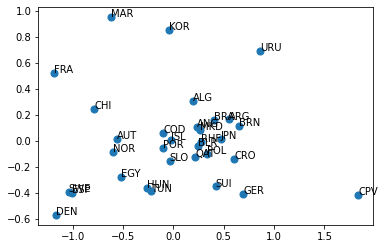

In [ ]:

team_goalkeepers_df_pca = estimator.fit_transform(team_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(team_goalkeepers_df_pca[:,0], team_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(team_goalkeepers_df_pca)):
    ax.annotate(team_goalkeepers_df.index[i], (team_goalkeepers_df_pca[i,0], team_goalkeepers_df_pca[i,1]))

### Sin porteros

[0.44153827 0.13581882 0.07407444 0.0591404  0.04569744]


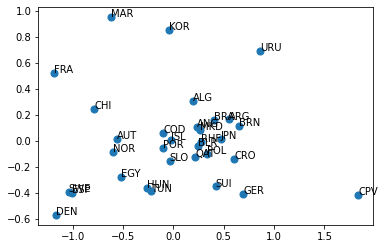

In [ ]:
team_no_goalkeepers_df_pca = estimator.fit_transform(team_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 


fig, ax = plt.subplots()
ax.scatter(team_no_goalkeepers_df_pca[:,0], team_no_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(team_no_goalkeepers_df_pca)):
    ax.annotate(team_no_goalkeepers_df.index[i], (team_no_goalkeepers_df_pca[i,0], team_no_goalkeepers_df_pca[i,1]))

## Por jugador

### Con porteros

[0.24948252 0.1988552  0.1051322  0.07097456 0.05542715]


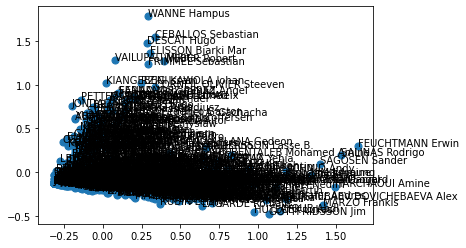

In [ ]:
player_goalkeepers_df_pca = estimator.fit_transform(player_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(player_goalkeepers_df_pca[:,0], player_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(player_goalkeepers_df_pca)):
    ax.annotate(player_goalkeepers_df.index[i], (player_goalkeepers_df_pca[i,0], player_goalkeepers_df_pca[i,1]))

### Sin porteros

[0.23892466 0.19961115 0.10577054 0.07260699 0.05673736]


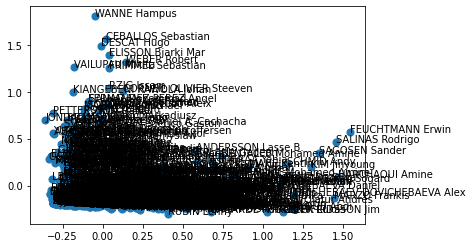

In [ ]:
player_no_goalkeepers_df_pca = estimator.fit_transform(player_no_goalkeepers_df[['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed', 'TF', '2Min', 'AS', 'ST', 'BS']])
print(estimator.explained_variance_ratio_) 

fig, ax = plt.subplots()
ax.scatter(player_no_goalkeepers_df_pca[:,0], player_no_goalkeepers_df_pca[:,1] ,s=50)

for i in range(0,len(player_no_goalkeepers_df_pca)):
    ax.annotate(player_no_goalkeepers_df.index[i], (player_no_goalkeepers_df_pca[i,0], player_no_goalkeepers_df_pca[i,1]))

# Ejecución del algoritmo

Por lo que se nos ha comentado en clase, no hay ninguna técnica específica para calcular el mejor valor del número de componentes al contrario de lo que pasaba con la K de K-means.